In [1]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import re

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('webtext')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


True

In [3]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

Read Data from asample txt file and remove unnecessary characters and white spaces

In [4]:
def read_files_data(stop_word_removal='no'):
  file_contents = []
  
  with open('jef_archer.txt') as f:
    file_contents = f.read()
  
  text = []
  for val in file_contents.split('.'):
    sent = re.findall("[A-Za-z]+", val)
    line = ''
    for words in sent:
      if stop_word_removal == 'yes': 
        if len(words) > 1 and words not in stop_words:
          line = line + ' ' + words
      else:
        if len(words) > 1 :
          line = line + ' ' + words
    text.append(line)
  return text

Generate  a dictionary--------

word_to_index : Map each word to an value {'teacher': 0, 'student': 1}

index_to_word : Map each value to an  vaword {0: 'teacher', 1: 'student'}

corpus  : Data consisting of all the words

vocab_size : Number of unique words in the corpus

In [5]:
def generate_dictinoary(text):
  word_to_index= dict()
  index_to_word = dict()
  corpus = []
  count = 0
  vocab_size = 0
  for row in text:
    for word in row.split():
      word = word.lower()    #Convert words to lowercase
      corpus.append(word)
      if word_to_index.get(word) == None:
        word_to_index.update ( {word : count})
        index_to_word.update ( {count : word })
        count  += 1
  vocab_size = len(word_to_index)
  length_of_corpus = len(corpus)
  
  return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

Example corpus and word generation

In [6]:
text = ['Best way to success is through hardwork and persistence']
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary(text)
print('Number of unique words:' , vocab_size)
print('word_to_index : ',word_to_index)
print('index_to_word : ',index_to_word)
print('corpus:',corpus)
print('Length of corpus :',length_of_corpus)

Number of unique words: 9
word_to_index :  {'best': 0, 'way': 1, 'to': 2, 'success': 3, 'is': 4, 'through': 5, 'hardwork': 6, 'and': 7, 'persistence': 8}
index_to_word :  {0: 'best', 1: 'way', 2: 'to', 3: 'success', 4: 'is', 5: 'through', 6: 'hardwork', 7: 'and', 8: 'persistence'}
corpus: ['best', 'way', 'to', 'success', 'is', 'through', 'hardwork', 'and', 'persistence']
Length of corpus : 9


The training data Example:

Window size = 2, Vocab size = 9

Example
Target word = best    
Context words = (way,to)

Target_word_one_hot_vector = [1, 0, 0, 0, 0, 0, 0, 0, 0]
Context_word_one_hot_vector = [0, 1, 1, 0, 0, 0, 0, 0, 0]

Target word = way    

Context words = (best,to,success)
Target_word_one_hot_vector = [0, 1, 0, 0, 0, 0, 0, 0, 0]
Context_word_one_hot_vector= [1, 0, 1, 1, 0, 0, 0, 0, 0]

In [7]:
def one_hot_encoding(target_word,context_words,vocab_size,word_to_index):
  
  trgt_word_vector = np.zeros(vocab_size)
  index_of_word_dictionary = word_to_index.get(target_word) 
  trgt_word_vector[index_of_word_dictionary] = 1
  ctxt_word_vector = np.zeros(vocab_size)
  
  for word in context_words:
    index_of_word_dictionary = word_to_index.get(word) 
    ctxt_word_vector[index_of_word_dictionary] = 1
    
  return trgt_word_vector,ctxt_word_vector

In [8]:
def generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus,sample=None):

  training_data =  []
  training_sample_words =  []

  for i,word in enumerate(corpus):
    index_target_word = i
    target_word = word
    context_words = []

    if i == 0:
      # trgt_word_index:(0), ctxt_word_index:(1,2)
      context_words = [corpus[x] for x in range(i + 1 , window_size + 1)] 

    elif i == len(corpus)-1:
      # trgt_word_index:(9), ctxt_word_index:(8,7), length_of_corpus = 10
      context_words = [corpus[x] for x in range(length_of_corpus - 2 ,length_of_corpus -2 - window_size  , -1 )]

    else:
      before_target_word_index = index_target_word - 1
      for x in range(before_target_word_index, before_target_word_index - window_size , -1):
          if x >=0:
              context_words.extend([corpus[x]])

      #After the middle target word
      after_target_word_index = index_target_word + 1
      for x in range(after_target_word_index, after_target_word_index + window_size):
          if x < len(corpus):
              context_words.extend([corpus[x]])


  trgt_word_vector,ctxt_word_vector = one_hot_encoding(target_word,context_words,vocab_size,word_to_index)
  training_data.append([trgt_word_vector,ctxt_word_vector])   
  
  if sample is not None:
      training_sample_words.append([target_word,context_words])   
    
  return training_data,training_sample_words

In [9]:
text = ['Best way to success is through extreme hardwork and persistence']
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary(text)

window_size = 2
training_data,training_sample_words = generate_training_data(corpus,2,vocab_size,word_to_index,length_of_corpus,'yes')

for i in range(len(training_data)):
    print('*' * 50)
    print('Target word:%s . Target vector: %s ' %(training_sample_words[i][0],training_data[i][0]))
    print('Context word:%s . Context  vector: %s ' %(training_sample_words[i][1],training_data[i][1]))


**************************************************
Target word:persistence . Target vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 
Context word:['and', 'hardwork'] . Context  vector: [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 


In [10]:
def forward_prop(weight_inp_hidden,weight_hidden_output,target_word_vector):
    
    #target_word_vector = x , weight_inp_hidden =  weights for input layer to hidden layer  
    hidden_layer = np.dot(weight_inp_hidden.T, target_word_vector)
    
    #weight_hidden_output = weights for hidden layer to output layer
    u = np.dot(weight_hidden_output.T, hidden_layer)
    
    y_predicted = softmax(u)
    
    return y_predicted, hidden_layer, u
  
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def backward_prop(weight_inp_hidden,weight_hidden_output,total_error, hidden_layer, target_word_vector,learning_rate):
    
    dl_weight_inp_hidden = np.outer(target_word_vector, np.dot(weight_hidden_output, total_error.T))
    dl_weight_hidden_output = np.outer(hidden_layer, total_error)
    
    # Update weights
    weight_inp_hidden = weight_inp_hidden - (learning_rate * dl_weight_inp_hidden)
    weight_hidden_output = weight_hidden_output - (learning_rate * dl_weight_hidden_output)
    
    return weight_inp_hidden,weight_hidden_output

In [11]:
def calculate_error(y_pred,context_words):
    
    total_error = [None] * len(y_pred)
    index_of_1_in_context_words = {}
    
    for index in np.where(context_words == 1)[0]:
        index_of_1_in_context_words.update ( {index : 'yes'} )
        
    number_of_1_in_context_vector = len(index_of_1_in_context_words)
    
    for i,value in enumerate(y_pred):
        
        if index_of_1_in_context_words.get(i) != None:
            total_error[i]= (value-1) + ( (number_of_1_in_context_vector -1) * value)
        else:
            total_error[i]= (number_of_1_in_context_vector * value)
                  
    return  np.array(total_error)

In [12]:
def calculate_loss(u,ctx):
    
    sum_1 = 0
    for index in np.where(ctx==1)[0]:
        sum_1 = sum_1 + u[index]
    
    sum_1 = -sum_1
    sum_2 = len(np.where(ctx==1)[0]) * np.log(np.sum(np.exp(u)))
    
    total_loss = sum_1 + sum_2
    return total_loss

In [13]:
def train(word_embedding_dimension,window_size,epochs,training_data,learning_rate,disp = 'no',interval=-1):
    
    weights_input_hidden = np.random.uniform(-1, 1, (vocab_size, word_embedding_dimension))
    weights_hidden_output = np.random.uniform(-1, 1, (word_embedding_dimension, vocab_size))
    
    #For analysis purposes
    epoch_loss = []
    weights_1 = []
    weights_2 = []
    
    for epoch in range(epochs):
        loss = 0

        for target,context in training_data:
            y_pred, hidden_layer, u = forward_prop(weights_input_hidden,weights_hidden_output,target)

            total_error = calculate_error(y_pred, context)

            weights_input_hidden,weights_hidden_output = backward_prop(
                weights_input_hidden,weights_hidden_output ,total_error, hidden_layer, target,learning_rate
            )

            loss_temp = calculate_loss(u,context)
            loss += loss_temp
        
        epoch_loss.append( loss )
        weights_1.append(weights_input_hidden)
        weights_2.append(weights_hidden_output)
        
        if disp == 'yes':
            if epoch ==0 or epoch % interval ==0 or epoch == epochs -1:
                print('Epoch: %s. Loss:%s' %(epoch,loss))
    return epoch_loss,np.array(weights_1),np.array(weights_2)

In [14]:
def cosine_similarity(word,weight,word_to_index,vocab_size,index_to_word):
    
    index = word_to_index[word]
    word_vector_1 = weight[index]
    word_similarity = {}

    for i in range(vocab_size):
        
        word_vector_2 = weight[i]
        
        theta_sum = np.dot(word_vector_1, word_vector_2)
        theta_den = np.linalg.norm(word_vector_1) * np.linalg.norm(word_vector_2)
        theta = theta_sum / theta_den
        
        word = index_to_word[i]
        word_similarity[word] = theta
    
    return word_similarity #words_sorted

In [15]:
def print_similar_words(top_n_words,weight,msg,words_subset):
    
    columns=[]
    
    for i in range(0,len(words_subset)):
        columns.append('similar:' +str(i+1) )
        
    df = pd.DataFrame(columns=columns,index=words_subset)
    df.head()
    
    row = 0
    for word in words_subset:
        similarity_matrix = cosine_similarity(word,weight,word_to_index,vocab_size,index_to_word)
        col = 0
        
        words_sorted = dict(sorted(similarity_matrix.items(), key=lambda x: x[1], reverse=True)[1:top_n_words+1])

        for similar_word,similarity_value in words_sorted.items():
            df.iloc[row][col] = (similar_word,round(similarity_value,2))
            col += 1
        row += 1
    styles = [dict(selector='caption', 
    props=[('text-align', 'center'),('font-size', '20px'),('color', 'red')])] 
    df = df.style.set_properties(**
                       {'color': 'green','border-color': 'blue','font-size':'14px'}
                      ).set_table_styles(styles).set_caption(msg)
    return df

In [16]:
def word_similarity_scatter_plot(index_to_word,weight,plot_title,fig,axes):
    
    labels = []
    tokens = []
    
    for key,value in index_to_word.items():
        tokens.append(weight[key])
        labels.append(value)
        
    #TSNE : Compressing the weights to 2 dimensions to plot the data
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    
    plt.figure(figsize=(5, 5)) 
    for i in range(len(x)):
        axes.scatter(x[i],y[i])
        axes.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title(plot_title)
    axes.set_title(plot_title, loc='center')

In [17]:
def plot_epoch_loss(lbl,loss_epoch,plot_title,path):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    i = 0
    fig = plt.figure(figsize=(10, 5), facecolor='w', edgecolor='k',dpi=80)
    plt.suptitle('Epoch vs Loss',fontsize=16)
    
    for key,loss in loss_epoch.items():
        
        
        epoch_count = range(1, len(loss) + 1)

        plt.plot(epoch_count, loss, 'r-',color=colors[i],linewidth=2.0,label = lbl + str(key))

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        i += 1

    plt.legend(framealpha=1, frameon=True,fontsize='large',edgecolor="inherit",shadow=True)
    plt.title(plot_title)
    plt.savefig(path+plot_title +'.png')
    plt.show()
    plt.close()   

In [18]:
path_to_save = 'epoc_loss_plot'
path_to_save_scatter_plot = 'word_similarity_scatter_plot'

In [20]:
window_size = 2
epochs = 100
learning_rate = 0.01
text = ['Best way to success is through hardwork and persistence']

word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary(text)
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.

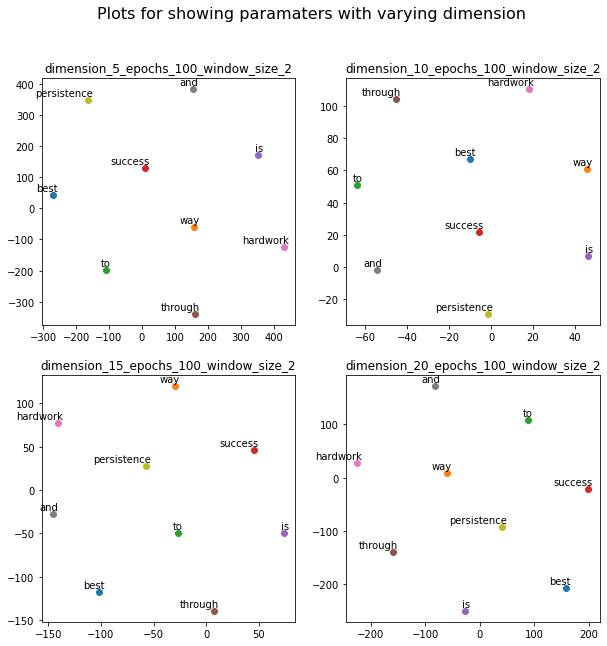

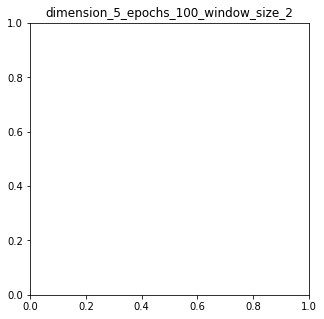

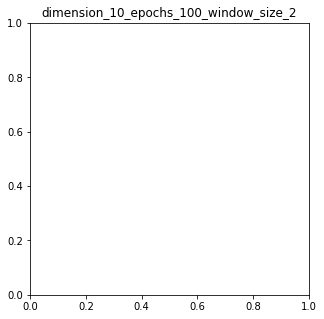

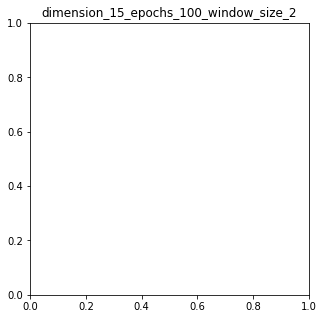

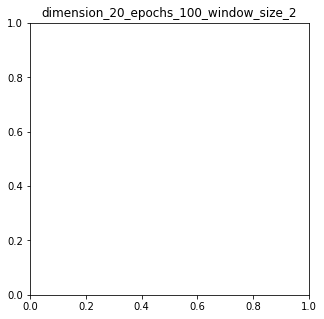

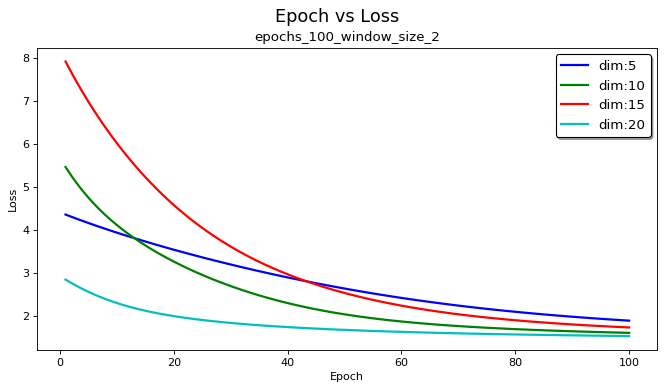

In [21]:
dimensions = [5,10,15,20]
loss_epoch = {}
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),)
fig.suptitle("Plots for showing paramaters with varying dimension", fontsize=16)
row=0
col=0
for dim in dimensions:
    
    epoch_loss,weights_1,weights_2 = train(dim,window_size,epochs,training_data,learning_rate)
    loss_epoch.update( {dim: epoch_loss} )
    
    word_similarity_scatter_plot(
        index_to_word,
        weights_1[epochs -1],
        'dimension_' + str(dim) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
        fig,
        axes[row][col]
    )
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1

plt.savefig('varying_dim' +'.png')        
plt.show()

plot_epoch_loss('dim:',loss_epoch,'epochs_' + str(epochs) + '_window_size_' +str(window_size),'')